# Exercise: Optimizer Bake-off!

Let's compare common optimizers (SGD, Adam, RMSprop) on a small CNN using Fashion-MNIST.

In this example we will use three dataset splits:
* `Train`: examples used for training the model using backpropagation
* `Validation`: examples used to evaluate model performance during training (e.g., to check for overfitting) and to choose the optimizer and hyperparameters
* `Test`: examples used to report the model performance at the very end

In [1]:
# Imports and global config
# No changes needed in this cell

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math, time, random
import numpy as np
import matplotlib.pyplot as plt


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(1234)


In [2]:
import torch
print("torch version:", torch.__version__)
print("torch cuda version:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

torch version: 2.9.1+cu130
torch cuda version: 13.0
cuda available: True
device count: 1


In [3]:
# Select device
# No changes needed in this cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data transforms
Now we define simple transforms for Fashion-MNIST (tensor + normalization).

In [4]:
# Student task: define data transforms (train and test)
# Complete the sections with **********

# Hint: Use transforms.ToTensor() and transforms.Normalize((0.5,), (0.5,))
# train_tfms = **********
# test_tfms  = **********
train_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_tfms = train_tfms


## Data loaders
Now we load Fashion-MNIST and create train/validation/test data loaders.

In [5]:
# Load datasets and create dataloaders

# No changes needed in this cell
train_ds = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=train_tfms
)
test_ds = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=test_tfms
)

# Create a small validation split from the training set
val_ratio = 0.1
val_size = int(len(train_ds) * val_ratio)
train_size = len(train_ds) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(1234)
)

# Create Data loaders: train_loader, val_loader, test_loader

# train_loader = DataLoader(**********)
# val_loader   = DataLoader(**********)
# test_loader  = DataLoader(**********)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)

(54000, 6000, 10000)

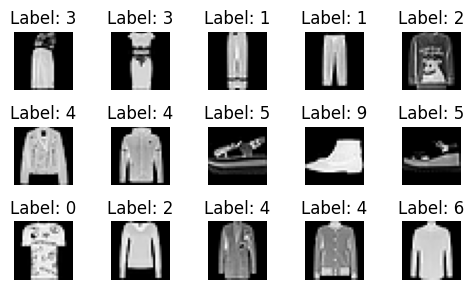

In [9]:
# Show some sample images
# No changes needed in this cell


def show_images(dataloader):
    batch = next(iter(dataloader))
    images, labels = batch
    fig, ax = plt.subplots(3, 5, figsize=(5, 3))
    for i in range(3):
        for j in range(5):
            ax[i, j].imshow(images[i * 5 + j].squeeze(), cmap="gray")
            ax[i, j].set_title(f"Label: {labels[i * 5 + j].item()}")
            ax[i, j].axis("off")
    plt.tight_layout()
    plt.show()


show_images(train_loader)

## Model
Let's define a tiny CNN suitable for 28×28 grayscale inputs.

In [6]:
# Tiny CNN model definition
# No changes needed in this cell


class TinyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28->14
        x = self.pool(F.relu(self.conv2(x)))  # 14->7
        x = self.drop(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = TinyCNN().to(device)

# Show the model size
sum(p.numel() for p in model.parameters()), model.__class__.__name__

(206922, 'TinyCNN')

## Metrics
Now we implement a simple accuracy function given logits and labels.

In [8]:
# Student task: Get the prediction values from logits and compute accuracy
# Complete the sections with **********


@torch.no_grad()
def accuracy_from_logits(logits, y):
    """Compute accuracy from model logits and true labels.

    logits: (B, C), y: (B,)
    """

    # Use argmax to get predicted class. Hint: dim = 1
    preds = "**********"
    preds = logits.argmax(dim=1)

    # Get boolean tensor of correct predictions, hint: use ==
    correct = preds == y


    # Return mean accuracy of the batch
    return correct.float().mean().item()


## Training utilities
Now we write the train loop body for one epoch and reuse it across optimizers.

In [9]:
# Student task: complete train_one_epoch with zero_grad → forward → loss.backward → optimizer.step
# Complete the sections with **********


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # TODO: implement the training loop steps. See train_one_epoch in for a hint
        # in https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html
        # **********  # zero the gradients
        # logits = **********  # run the model on the inputs to get the logits
        # loss = **********    # calculate the loss using criterion
        # **********           # run backpropagation to compute gradients
        # **********           # run a single optimization step
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # stats
        batch = x.size(0)
        running_loss += loss.item() * batch
        running_acc += accuracy_from_logits(logits, y) * batch
        n += batch
    return running_loss / n, running_acc / n

In [10]:
# Validation/test loop
# No changes needed in this cell
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        batch = x.size(0)
        total_loss += loss.item() * batch
        total_acc += accuracy_from_logits(logits, y) * batch
        n += batch
    return total_loss / n, total_acc / n

## Optimizers & hyperparameters
Now we set up three optimizers to compare (SGD, Adam, RMSprop).

In [11]:
# Student task: create an optimizers dict with configs for 'sgd', 'adam', 'rmsprop'
# Complete the sections with **********


# Function to create a fresh model instance for each optimizer
def make_fresh_model():
    m = TinyCNN().to(device)
    return m


# We use CrossEntropyLoss for classification problems
criterion = nn.CrossEntropyLoss()


# Function to create an optimizer for a given model
def make_optimizer(name, params):
    if name == "sgd":
        return optim.SGD(params, **optim_cfgs["sgd"])
    if name == "adam":
        return optim.Adam(params, **optim_cfgs["adam"])
    if name == "rmsprop":
        return optim.RMSprop(params, **optim_cfgs["rmsprop"])
    raise ValueError("Unknown optimizer")


# Optimizer configurations
# optim_cfgs = {
#     'sgd':     {'lr': **********, 'momentum': **********, 'weight_decay': ********__},
#     'adam':    {'lr': ********__, 'betas': ********__,    'weight_decay': ********__},
#     'rmsprop': {'lr': ********__, 'alpha': ********__,    'weight_decay': ********__},
# }
optim_cfgs = {
    'sgd':     {'lr':1e-2, 'momentum': 0.9, 'weight_decay': 1e-4,'nesterov': True},
    'adam':    {'lr': 1e-3, 'betas': (0.9, 0.999),    'weight_decay': 1e-4},
    'rmsprop': {'lr': 1e-3, 'alpha': 0.99,  'eps':1e-8},
}


## Training
Now we train each optimizer for a few epochs and record train/val metrics.

In [12]:
# Train each optimizer for a few epochs and store histories
# No changes needed in this cell
EPOCHS = 3  # keep short for classroom runtime
histories = {}

for opt_name in ["sgd", "adam", "rmsprop"]:
    print(f"\n=== Training with {opt_name.upper()} ===")
    set_seed(1234)  # reset for fair comparison
    model = make_fresh_model()
    optimizer = make_optimizer(opt_name, model.parameters())

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, EPOCHS + 1):
        tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, device)
        vl, va = evaluate(model, val_loader, criterion, device)
        train_losses.append(tl)
        train_accs.append(ta)
        val_losses.append(vl)
        val_accs.append(va)
        print(
            f"Epoch {epoch:02d} | train loss {tl:.4f} acc {ta:.4f} | val loss {vl:.4f} acc {va:.4f}"
        )

    histories[opt_name] = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "val_loss": val_losses,
        "val_acc": val_accs,
    }

print("\nDone training all optimizers.")


=== Training with SGD ===
Epoch 01 | train loss 0.5798 acc 0.7891 | val loss 0.3947 acc 0.8597
Epoch 02 | train loss 0.3555 acc 0.8704 | val loss 0.3403 acc 0.8763
Epoch 03 | train loss 0.3136 acc 0.8855 | val loss 0.2976 acc 0.8910

=== Training with ADAM ===
Epoch 01 | train loss 0.5021 acc 0.8184 | val loss 0.3919 acc 0.8592
Epoch 02 | train loss 0.3392 acc 0.8765 | val loss 0.3362 acc 0.8807
Epoch 03 | train loss 0.2933 acc 0.8916 | val loss 0.2857 acc 0.8968

=== Training with RMSPROP ===
Epoch 01 | train loss 0.4990 acc 0.8177 | val loss 0.3679 acc 0.8667
Epoch 02 | train loss 0.3377 acc 0.8772 | val loss 0.3295 acc 0.8793
Epoch 03 | train loss 0.2937 acc 0.8926 | val loss 0.2748 acc 0.8990

Done training all optimizers.


## Results
Now we plot validation accuracy curves to compare optimizers.

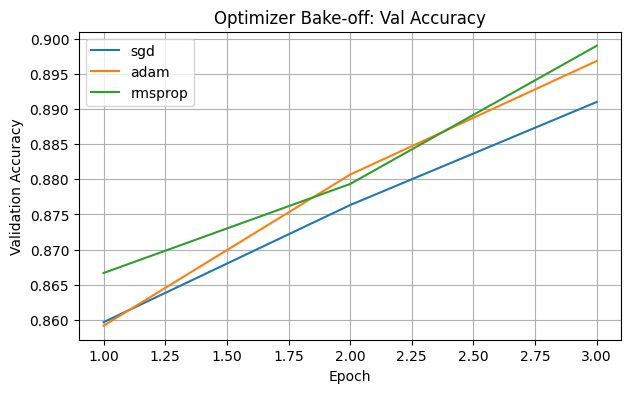

In [13]:
# Plot validation accuracy curves
# No changes needed in this cell
plt.figure(figsize=(7, 4))
for name, h in histories.items():
    plt.plot(range(1, len(h["val_acc"]) + 1), h["val_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Optimizer Bake-off: Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Final evaluation
Now we pick the best-performing optimizer by validation accuracy and report test accuracy.

In [15]:
# Evaluate the best optimizer on the test set
# No changes needed in this cell
best_name = max(histories.keys(), key=lambda n: max(histories[n]["val_acc"]))
print("Best by val acc:", best_name)

set_seed(1234)
best_model = make_fresh_model()
best_opt = make_optimizer(best_name, best_model.parameters())
for _ in range(3):
    train_one_epoch(best_model, train_loader, criterion, best_opt, device)
_, test_acc = evaluate(best_model, test_loader, criterion, device)
print(f"Test accuracy with {best_name.upper()}: {test_acc:.4f}")

Best by val acc: rmsprop
Test accuracy with RMSPROP: 0.8952


## Great job! 🎉🎉🎉

You've completed the optimizer bake-off exercise. Understanding how different optimizers affect training dynamics is crucial for building effective neural networks. Keep experimenting!

<br /><br /><br /><br /><br /><br /><br /><br /><br />